### Lección 8: Enfoque de Risk Parity

### Objetivos Notebook Lección 8. 

1. Implementar de forma manual el algoritmo de Hierarchical Risk Parity
2. Usar la librería Skfolio para encontrar el desempeño de técnicas de optimización de portafolios dentro y fuera de la muestra. 

### Implementación Funciones HRP

In [1]:
import pandas as pd
from librerias.finance_operators import calculateLogReturns
from librerias.Technical_Indicators import *
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from librerias.Backtest import *

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_30800\2272308311.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_assets_classes = pd.read_csv('datos\\'+'activos_dendograma.csv', encoding='utf-8', sep = ';')
df_assets_classes = df_assets_classes.set_index('id')
df_assets_classes = calculateLogReturns(df_assets_classes)

### Codificación de los Tickers
diccionario_tickers = {'G0QA_TRR_INDEX_VAL_LOC': 'UST 0-1', 
                       'GVQ0_TRR_INDEX_VAL_LOC': 'UST 1-5', 
                       'G6O2_TRR_INDEX_VAL_LOC': 'UST 5-10',
                       'GVQI_TRR_INDEX_VAL_LOC': 'TIPS 1-5', 
                       'G6QI_TRR_INDEX_VAL_LOC': 'TIPS 5-10', 
                       'C01A_TRR_INDEX_VAL_LOC': 'Corp 0-1', 
                       'CV10_TRR_INDEX_VAL_LOC': 'Corp 1-5',
                       'GS1V_TRR_INDEX_VAL_LOC': 'SSA', 
                       'M0A0_TRR_INDEX_VAL_LOC': 'MBS', 
                       'SPX_INDEX': 'Equity'
                       }
df_assets_classes = df_assets_classes.rename(columns = diccionario_tickers)
df_assets_classes

,UST 0-1,UST 1-5,UST 5-10,TIPS 1-5,TIPS 5-10,Corp 0-1,Corp 1-5,SSA,MBS,Equity
id,,,,,,,,,,
31/01/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/02/2006,-0.000040,-0.001118,-0.002253,-0.001911,-0.003200,-0.000160,-0.001295,-0.001087,-0.001705,0.001850
2/02/2006,0.000113,-0.000023,0.000253,-0.000893,-0.001013,-0.000020,0.000161,0.000106,0.000202,-0.009102
3/02/2006,0.000142,0.000231,0.001555,0.001004,0.002470,0.000140,0.000173,0.000064,0.000713,-0.005373
6/02/2006,0.000187,-0.000156,-0.000269,0.000095,0.000022,0.000370,-0.000008,-0.000120,0.000301,0.000783
...,...,...,...,...,...,...,...,...,...,...
14/12/2023,0.000242,0.002097,0.006359,0.004811,0.011709,0.000451,0.003303,0.003633,0.005817,0.002644
15/12/2023,0.000251,-0.000915,-0.000865,-0.001193,-0.001442,-0.000081,-0.000974,-0.000915,-0.002875,-0.000076
18/12/2023,0.000182,-0.000391,-0.001695,-0.000495,-0.002212,0.000262,-0.000299,-0.000383,-0.002225,0.004518


In [3]:
correlation_matrix = df_assets_classes.corr()
correlation_matrix

,UST 0-1,UST 1-5,UST 5-10,TIPS 1-5,TIPS 5-10,Corp 0-1,Corp 1-5,SSA,MBS,Equity
UST 0-1,1.000000,0.633364,0.468338,0.384323,0.338896,0.167888,0.405347,0.625509,0.374453,-0.167781
UST 1-5,0.633364,1.000000,0.923492,0.662850,0.723489,0.151490,0.781974,0.972968,0.768063,-0.266338
UST 5-10,0.468338,0.923492,1.000000,0.615224,0.787026,0.120519,0.750584,0.896817,0.797421,-0.286790
TIPS 1-5,0.384323,0.662850,0.615224,1.000000,0.887040,0.203841,0.658366,0.660166,0.582942,-0.029916
TIPS 5-10,0.338896,0.723489,0.787026,0.887040,1.000000,0.178860,0.693789,0.709752,0.705767,-0.111729
Corp 0-1,0.167888,0.151490,0.120519,0.203841,0.178860,1.000000,0.504217,0.143455,0.167834,0.019277
Corp 1-5,0.405347,0.781974,0.750584,0.658366,0.693789,0.504217,1.000000,0.783886,0.697253,-0.103146
SSA,0.625509,0.972968,0.896817,0.660166,0.709752,0.143455,0.783886,1.000000,0.744427,-0.255963
MBS,0.374453,0.768063,0.797421,0.582942,0.705767,0.167834,0.697253,0.744427,1.000000,-0.049023
Equity,-0.167781,-0.266338,-0.286790,-0.029916,-0.111729,0.019277,-0.103146,-0.255963,-0.049023,1.000000


In [4]:
cov = df_assets_classes.cov()
cov

,UST 0-1,UST 1-5,UST 5-10,TIPS 1-5,TIPS 5-10,Corp 0-1,Corp 1-5,SSA,MBS,Equity
UST 0-1,3.502929e-08,1.560636e-07,3.131282e-07,1.229736e-07,2.337181e-07,1.384048e-08,1.166709e-07,1.481217e-07,1.668940e-07,-3.878080e-07
UST 1-5,1.560636e-07,1.733267e-06,4.343235e-06,1.491929e-06,3.509741e-06,8.784783e-08,1.583233e-06,1.620694e-06,2.408007e-06,-4.326610e-06
UST 5-10,3.131282e-07,4.343235e-06,1.276129e-05,3.757341e-06,1.035969e-05,1.896346e-07,4.123505e-06,4.053410e-06,6.783640e-06,-1.263655e-05
TIPS 1-5,1.229736e-07,1.491929e-06,3.757341e-06,2.922808e-06,5.587966e-06,1.534997e-07,1.730962e-06,1.427983e-06,2.373306e-06,-6.311610e-07
TIPS 5-10,2.337181e-07,3.509741e-06,1.035969e-05,5.587966e-06,1.357753e-05,2.902943e-07,3.931499e-06,3.308922e-06,6.192984e-06,-5.079490e-06
Corp 0-1,1.384048e-08,8.784783e-08,1.896346e-07,1.534997e-07,2.902943e-07,1.940129e-07,3.415492e-07,7.994675e-08,1.760449e-07,1.048760e-07
Corp 1-5,1.166709e-07,1.583233e-06,4.123505e-06,1.730962e-06,3.931499e-06,3.415492e-07,2.365049e-06,1.525256e-06,2.553517e-06,-1.957741e-06
SSA,1.481217e-07,1.620694e-06,4.053410e-06,1.427983e-06,3.308922e-06,7.994675e-08,1.525256e-06,1.600808e-06,2.242952e-06,-3.997098e-06
MBS,1.668940e-07,2.408007e-06,6.783640e-06,2.373306e-06,6.192984e-06,1.760449e-07,2.553517e-06,2.242952e-06,5.670954e-06,-1.436357e-06
Equity,-3.878080e-07,-4.326610e-06,-1.263655e-05,-6.311610e-07,-5.079490e-06,1.048760e-07,-1.957741e-06,-3.997098e-06,-1.436357e-06,1.522571e-04


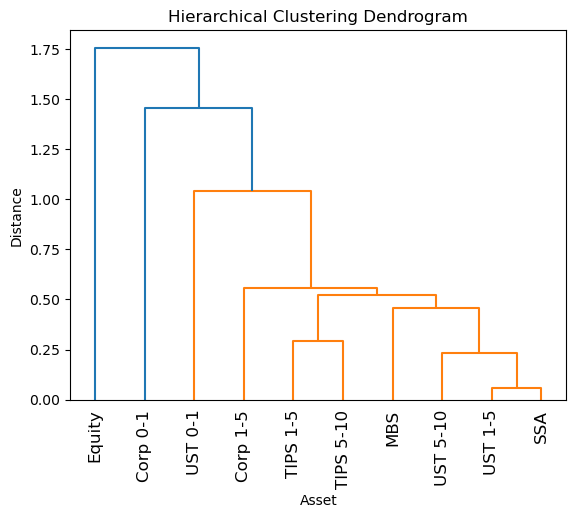

In [5]:
linkage_matrix = linkage(correlation_matrix, method='single')
# Plot the dendrogram
dendrogram(linkage_matrix, labels=[*diccionario_tickers.values()])
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Asset')
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

In [6]:
def get_quasi_diag(link):
    
    # sort clustered items by distance    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # odd numers as index
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items # 
        
        sort_ix[i] = link[j,0] # item 1
        
        df0  = pd.Series(link[j, 1], index=i+1)
        
        sort_ix = pd.concat([sort_ix,df0], axis = 0)
        
        sort_ix = sort_ix.sort_index()

        sort_ix.index = range(sort_ix.shape[0])
        
    
    return sort_ix.tolist()

In [7]:
sort_ix = get_quasi_diag(linkage_matrix)
sort_ix

[9, 5, 0, 6, 3, 4, 8, 2, 1, 7]

In [8]:
initial_order = [*diccionario_tickers.values()]
sorted_lst = [df_assets_classes.columns[i] for i in sort_ix]
assets_df = pd.DataFrame(sorted_lst, initial_order).reset_index()
assets_df = assets_df.rename(columns = {'index':'Initial Order', 0:'New Order'})
assets_df

,Initial Order,New Order
0,UST 0-1,Equity
1,UST 1-5,Corp 0-1
2,UST 5-10,UST 0-1
3,TIPS 1-5,Corp 1-5
4,TIPS 5-10,TIPS 1-5
5,Corp 0-1,TIPS 5-10
6,Corp 1-5,MBS
7,SSA,UST 5-10
8,MBS,UST 1-5
9,Equity,SSA


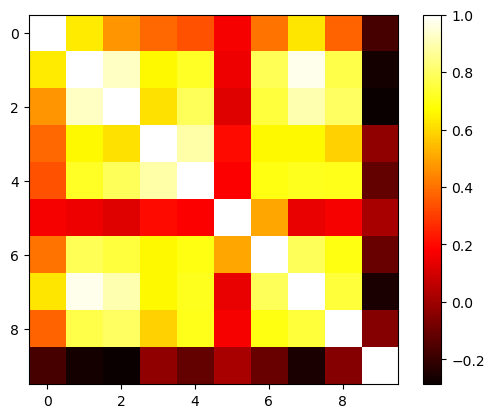

In [9]:
correlation_matrix = correlation_matrix.loc[initial_order, initial_order]
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

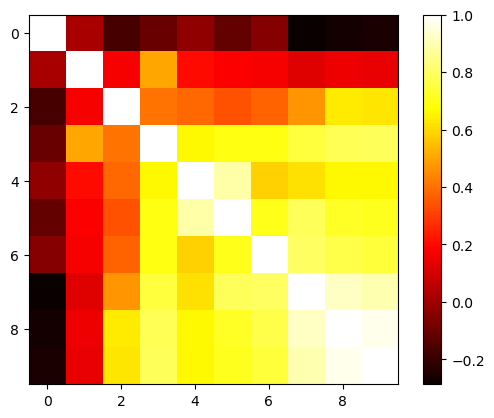

In [10]:
correlation_matrix = correlation_matrix.loc[sorted_lst, sorted_lst]
correlation_matrix.index = sort_ix
correlation_matrix.columns = sort_ix
correlation_matrix
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
### Los labels no es posible redefinirlos con matplotlib, si se puede hacer con Seaborn. 

In [11]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        """
        [[9, 5, 0, 6, 3], [4, 8, 2 ,1, 7]]
        [[9, 5], [0, 6, 3], [4, 8], [2, 1, 7]]
        [[9], [5], [0], [6, 3], [4], [8], [2], [1], [7]]
        [[9], [5], [0], [6], [3], [4], [8], [2], [1] , [7]]
        
        """
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        print(c_items)
        # now it has 2
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha

        print(w)
    return w

In [12]:
def calculate_corr_m(variance_df, columns = None):
    # 
    number_of_assets = len(variance_df.columns)
    Rho = np.ones((number_of_assets,number_of_assets))  # Matriz de correlaciones
    for i in range(number_of_assets):  
        j = i+1
        while j < number_of_assets:
            Rho[i,j] = variance_df.iloc[i,j]/np.sqrt(variance_df.iloc[i,i]*variance_df.iloc[j,j])
            Rho[j,i] = Rho[i,j]
            j+=1
    if(columns is not None):
        Rho = pd.DataFrame(Rho, index=columns, columns=columns)
    return Rho


In [13]:
weights = get_rec_bipart(cov, sort_ix)
weights

[[9, 5, 0, 6, 3], [4, 8, 2, 1, 7]]
9    0.983866
5    0.983866
0    0.983866
6    0.983866
3    0.983866
4    0.016134
8    0.016134
2    0.016134
1    0.016134
7    0.016134
dtype: float64
[[9, 5], [0, 6, 3], [4, 8], [2, 1, 7]]
9    0.170840
5    0.170840
0    0.813026
6    0.813026
3    0.813026
4    0.003729
8    0.003729
2    0.012405
1    0.012405
7    0.012405
dtype: float64
[[9], [5], [0], [6, 3], [4], [8], [2], [1, 7]]
9    0.000217
5    0.170623
0    0.800069
6    0.012956
3    0.012956
4    0.001099
8    0.002630
2    0.001414
1    0.010992
7    0.010992
dtype: float64
[[6], [3], [1], [7]]
9    0.000217
5    0.170623
0    0.800069
6    0.007161
3    0.005795
4    0.001099
8    0.002630
2    0.001414
1    0.005277
7    0.005714
dtype: float64
[]
9    0.000217
5    0.170623
0    0.800069
6    0.007161
3    0.005795
4    0.001099
8    0.002630
2    0.001414
1    0.005277
7    0.005714
dtype: float64


C:\Users\jcamargo\AppData\Local\Temp\ipykernel_30800\4100947805.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.98386584 0.98386584 0.98386584 0.98386584 0.98386584]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[c_items0] *= alpha


9    0.000217
5    0.170623
0    0.800069
6    0.007161
3    0.005795
4    0.001099
8    0.002630
2    0.001414
1    0.005277
7    0.005714
dtype: float64

In [14]:
weights_HRP = pd.Series(data = weights)
shuffled_list = np.take([*diccionario_tickers.values()], sort_ix).tolist()
weights_HRP.index = shuffled_list
weights_HRP = weights_HRP.loc[[*diccionario_tickers.values()]] 
weights_HRP

UST 0-1      0.800069
UST 1-5      0.005277
UST 5-10     0.001414
TIPS 1-5     0.005795
TIPS 5-10    0.001099
Corp 0-1     0.170623
Corp 1-5     0.007161
SSA          0.005714
MBS          0.002630
Equity       0.000217
dtype: float64

In [15]:
weights_HRP*100

UST 0-1      80.006935
UST 1-5       0.527742
UST 5-10      0.141366
TIPS 1-5      0.579484
TIPS 5-10     0.109863
Corp 0-1     17.062278
Corp 1-5      0.716146
SSA           0.571410
MBS           0.263036
Equity        0.021742
dtype: float64

Termina con un allocation importante en tesoros 0-1 y también en corporativos 0-1. 

### Implementación con Librería 'Skfolio' de Risk Parity, Hierarchical Risk Parity

A continuación se muestra un ejemplo de la implementación de Risk Parity y Hierarchical Risk Parity usando la librería Skfolio. Esta librería guarda una sintaxis similar a la de Scikitlearn permitiendo poder separar los datos entre train y test. También permite hacer un gridsearch para tunear los parámetros. 

In [16]:
import pandas as pd
from librerias.finance_operators import calculateLogReturns
from librerias.Technical_Indicators import *
from scipy.cluster.hierarchy import linkage, dendrogram
from librerias.Backtest import *
from skfolio.preprocessing import prices_to_returns

In [17]:
indices = pd.read_csv('Datos\\'+'Índices.csv', sep = ';')
indices

,ID,Cash,Tips,Corporativos,MBS,Equity,Emergentes
0,2006-01-31,104.630,101.7361,353.795,1267.487,1937.93,192.57
1,2006-02-01,104.643,101.5331,353.337,1265.328,1941.75,192.37
2,2006-02-02,104.655,101.4291,353.394,1265.584,1924.67,192.46
3,2006-02-03,104.671,101.5572,353.455,1266.487,1914.50,192.64
4,2006-02-06,104.707,101.5455,353.452,1266.868,1916.04,192.80
...,...,...,...,...,...,...,...
4581,2023-08-15,129.716,160.8998,582.801,2015.545,9549.17,405.38
4582,2023-08-16,129.735,160.6423,582.045,2011.529,9478.54,404.87
4583,2023-08-17,129.755,160.7714,582.219,2009.425,9407.27,403.71
4584,2023-08-18,129.811,160.9014,582.552,2014.660,9406.50,403.62


In [18]:
indices.index = pd.to_datetime(indices['ID'])
indices = indices.drop(columns=['ID'])
indices_returns = prices_to_returns(indices)

In [19]:
from plotly.io import show
from sklearn.model_selection import train_test_split
from skfolio import Population, RiskMeasure
from skfolio.datasets import load_sp500_dataset
from skfolio.optimization import InverseVolatility, RiskBudgeting
from skfolio.preprocessing import prices_to_returns

In [20]:
# Se puede segmentar los datos en entrenamiento y prueba con el mismo método de Scikit-Learn
X_train, X_test = train_test_split(indices_returns, test_size=0.33, shuffle=False)
X_train = X_train.dropna()
X_train

,Cash,Tips,Corporativos,MBS,Equity,Emergentes
ID,,,,,,
2006-02-01,0.000124,-0.001995,-0.001295,-0.001703,0.001971,-0.001039
2006-02-02,0.000115,-0.001024,0.000161,0.000202,-0.008796,0.000468
2006-02-03,0.000153,0.001263,0.000173,0.000714,-0.005284,0.000935
2006-02-06,0.000344,-0.000115,-0.000008,0.000301,0.000804,0.000831
2006-02-07,0.000096,-0.001403,0.000065,0.000057,-0.008069,-0.000311
...,...,...,...,...,...,...
2017-10-26,0.000017,-0.000010,-0.000184,-0.001043,0.001271,-0.000533
2017-10-27,0.000051,0.001311,0.000591,0.001871,0.008074,0.000381
2017-10-30,0.000042,0.001591,0.001172,0.002481,-0.003112,0.001675


In [21]:
model = RiskBudgeting(
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Risk Parity - Variance"),
)
model.fit(X_train)
model.weights_

array([0.8666364 , 0.03202029, 0.03718986, 0.03010838, 0.00900681,
       0.02503826])

In [22]:
bench = InverseVolatility(portfolio_params=dict(name="Inverse Vol"))
bench.fit(X_train)
bench.weights_

array([0.81425724, 0.04826696, 0.052782  , 0.0419618 , 0.00665524,
       0.03607676])

In [23]:
ptf_model_train = model.predict(X_train)
ptf_model_train.plot_contribution(measure=RiskMeasure.ANNUALIZED_VARIANCE)

In [24]:
ptf_bench_train = bench.predict(X_train)
ptf_bench_train.plot_contribution(measure=RiskMeasure.ANNUALIZED_VARIANCE)

In [25]:
ptf_model_test = model.predict(X_test.dropna())
ptf_bench_test = bench.predict(X_test.dropna())

In [26]:
population = Population([ptf_bench_train, ptf_model_train])
# %%
# Let's plot each portfolio composition:
population.plot_composition()
# %%
# Let's plot each portfolio cumulative returns:
#fig = population.plot_cumulative_returns()
#show(fig)
# %%
# |
#
# Finally, we print a full summary of both strategies evaluated on the test set:
population.summary()

c:\Users\jcamargo\Anaconda3\envs\CEFA_2024\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\jcamargo\Anaconda3\envs\CEFA_2024\lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



,Inverse Vol,Risk Parity - Variance
Mean,0.0062%,0.0057%
Annualized Mean,1.57%,1.43%
Variance,0.000008%,0.000005%
Annualized Variance,0.0020%,0.0012%
Semi-Variance,0.000004%,0.000002%
Annualized Semi-Variance,0.0010%,0.00061%
Standard Deviation,0.028%,0.022%
Annualized Standard Deviation,0.44%,0.34%
Semi-Deviation,0.020%,0.016%
Annualized Semi-Deviation,0.32%,0.25%


In [27]:
from plotly.io import show
from sklearn.model_selection import GridSearchCV, train_test_split

from skfolio import Population, RatioMeasure, RiskMeasure
from skfolio.cluster import HierarchicalClustering, LinkageMethod
from skfolio.datasets import load_ftse100_dataset
from skfolio.distance import KendallDistance, PearsonDistance
from skfolio.metrics import make_scorer
from skfolio.model_selection import (
    CombinatorialPurgedCV,
    WalkForward,
    cross_val_predict,
)
from skfolio.optimization import (
    EqualWeighted,
    HierarchicalRiskParity,
)

from skfolio.preprocessing import prices_to_returns

model_hrp = HierarchicalRiskParity(
    risk_measure=RiskMeasure.VARIANCE,
    hierarchical_clustering_estimator=HierarchicalClustering(),
)

model_hrp.fit(X_train)
model_hrp.weights_

array([9.92721380e-01, 1.47286970e-03, 1.76131144e-03, 2.63303867e-03,
       6.63179542e-05, 1.34508262e-03])

In [28]:
ptf_hrp_test = model_hrp.predict(X_test.dropna())
ptf_model_test

<Portfolio Risk Parity - Variance>

In [29]:
population = Population([ptf_model_test, ptf_bench_test, ptf_hrp_test])

# %%
# Let's plot each portfolio composition:
population.plot_composition()

# %%
# Let's plot each portfolio cumulative returns:
#fig = population.plot_cumulative_returns()
#show(fig)

# %%
# |
#
# Finally, we print a full summary of both strategies evaluated on the test set:
summary_df = population.summary()

c:\Users\jcamargo\Anaconda3\envs\CEFA_2024\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [30]:
summary_df = summary_df.drop(index = ['Ulcer Index', 'Gini Mean Difference', 'Worst Realization'
                         , 'EVaR at 95%', 'EDaR at 95%', 'EVaR Ratio at 95%'
                         , 'First Lower Partial Moment', 'Entropic Risk Measure at 95%'
                         , 'Fourth Central Moment', 'Fourth Lower Partial Moment', 'Worst Realization Ratio'
                         ,'Ulcer Index Ratio', 'EDaR Ratio at 95%', 'First Lower Partial Moment Ratio'
                         , 'Entropic Risk Measure Ratio at 95%', 'Gini Mean Difference Ratio', 'Assets number', 'Mean Absolute Deviation'])
summary_df

,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity
Mean,0.0063%,0.0061%,0.0062%
Annualized Mean,1.60%,1.54%,1.57%
Variance,0.000013%,0.000016%,0.000009%
Annualized Variance,0.0033%,0.0041%,0.0023%
Semi-Variance,0.000004%,0.000006%,0.000000%
Annualized Semi-Variance,0.00096%,0.0015%,0.000047%
Standard Deviation,0.036%,0.040%,0.030%
Annualized Standard Deviation,0.57%,0.64%,0.48%
Semi-Deviation,0.020%,0.025%,0.0043%
Annualized Semi-Deviation,0.31%,0.39%,0.069%


In [31]:
def convert_to_float(val):
    try:
        if '%' in val:
            return float(val.strip('%')) / 100
        return float(val)
    except ValueError:
        return val

summary_df_float = summary_df.applymap(convert_to_float)
summary_df_float = summary_df_float.round(3)
summary_df_float

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_30800\848800738.py:9: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity
Mean,0.000,0.000,0.000
Annualized Mean,0.016,0.015,0.016
Variance,0.000,0.000,0.000
Annualized Variance,0.000,0.000,0.000
Semi-Variance,0.000,0.000,0.000
Annualized Semi-Variance,0.000,0.000,0.000
Standard Deviation,0.000,0.000,0.000
Annualized Standard Deviation,0.006,0.006,0.005
Semi-Deviation,0.000,0.000,0.000
Annualized Semi-Deviation,0.003,0.004,0.001


In [32]:
list_of_positive_metrics = ['Mean', 'Annualized Mean', 'Skew', 'Sortino Ratio', 'Sharpe Ratio', 'Calmar Ratio', ]
summary_df_float = summary_df_float.loc[list_of_positive_metrics,:]
summary_df_float = summary_df_float
summary_df_float

,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity
Mean,0.000,0.000,0.000
Annualized Mean,0.016,0.015,0.016
Skew,11.260,5.970,34.880
Sortino Ratio,0.320,0.250,1.440
Sharpe Ratio,0.180,0.150,0.210
Calmar Ratio,0.005,0.004,0.170


In [33]:
list_of_positive_metrics = ['Mean', 'Annualized Mean', 'Skew', 'Sortino Ratio', 'Sharpe Ratio', 'Calmar Ratio']
summary_df

,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity
Mean,0.0063%,0.0061%,0.0062%
Annualized Mean,1.60%,1.54%,1.57%
Variance,0.000013%,0.000016%,0.000009%
Annualized Variance,0.0033%,0.0041%,0.0023%
Semi-Variance,0.000004%,0.000006%,0.000000%
Annualized Semi-Variance,0.00096%,0.0015%,0.000047%
Standard Deviation,0.036%,0.040%,0.030%
Annualized Standard Deviation,0.57%,0.64%,0.48%
Semi-Deviation,0.020%,0.025%,0.0043%
Annualized Semi-Deviation,0.31%,0.39%,0.069%


In [34]:
### Positive Metrics 
positive_metrics = summary_df.loc[list_of_positive_metrics,:]
positive_metrics_float = summary_df_float.loc[list_of_positive_metrics,:]
positive_metrics['Best Portfolio'] = positive_metrics_float.idxmax(axis = 1)
positive_metrics

,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity,Best Portfolio
Mean,0.0063%,0.0061%,0.0062%,Risk Parity - Variance
Annualized Mean,1.60%,1.54%,1.57%,Risk Parity - Variance
Skew,11.26,5.97,34.88,HierarchicalRiskParity
Sortino Ratio,0.32,0.25,1.44,HierarchicalRiskParity
Sharpe Ratio,0.18,0.15,0.21,HierarchicalRiskParity
Calmar Ratio,0.0051,0.0036,0.17,HierarchicalRiskParity


In [35]:
### Positive Metrics 
list_of_negative_metrics = ['Value at Risk at 95%', 'CDaR at 95%', 'Annualized Variance', 'MAX Drawdown', 'Average Drawdown']
negative_metrics = summary_df.loc[list_of_negative_metrics,:]
negative_metrics_float = summary_df_float.loc[list_of_positive_metrics,:]
negative_metrics['Best Portfolio'] = negative_metrics.idxmin(axis = 1)
negative_metrics

,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity,Best Portfolio
Value at Risk at 95%,0.033%,0.043%,0.0014%,HierarchicalRiskParity
CDaR at 95%,0.96%,1.35%,0.016%,HierarchicalRiskParity
Annualized Variance,0.0033%,0.0041%,0.0023%,HierarchicalRiskParity
MAX Drawdown,1.26%,1.73%,0.036%,HierarchicalRiskParity
Average Drawdown,0.11%,0.17%,0.0012%,HierarchicalRiskParity


In [36]:
pd.concat([positive_metrics, negative_metrics], axis = 0)

,Risk Parity - Variance,Inverse Vol,HierarchicalRiskParity,Best Portfolio
Mean,0.0063%,0.0061%,0.0062%,Risk Parity - Variance
Annualized Mean,1.60%,1.54%,1.57%,Risk Parity - Variance
Skew,11.26,5.97,34.88,HierarchicalRiskParity
Sortino Ratio,0.32,0.25,1.44,HierarchicalRiskParity
Sharpe Ratio,0.18,0.15,0.21,HierarchicalRiskParity
Calmar Ratio,0.0051,0.0036,0.17,HierarchicalRiskParity
Value at Risk at 95%,0.033%,0.043%,0.0014%,HierarchicalRiskParity
CDaR at 95%,0.96%,1.35%,0.016%,HierarchicalRiskParity
Annualized Variance,0.0033%,0.0041%,0.0023%,HierarchicalRiskParity
MAX Drawdown,1.26%,1.73%,0.036%,HierarchicalRiskParity
